In [ ]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
# the dataset path
TEXT_DATA_DIR = r'../input/20-newsgroup-original/20_newsgroup/20_newsgroup/'
#the path for Glove embeddings
GLOVE_DIR = r'./drive/My Drive/Colab Notebooks/'
# make the max word length to be constant
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.25
batch_size = 256
epochs = 50

In [ ]:
## preparing dataset
from sklearn.datasets import fetch_20newsgroups


categories=['talk.politics.mideast', 'rec.sport.hockey','comp.graphics', 'sci.med', 'sci.space', 'comp.sys.ibm.pc.hardware', 'alt.atheism']
df_train=fetch_20newsgroups(subset='train',shuffle=True,random_state=42)
df_test=fetch_20newsgroups(subset='test',shuffle=True,random_state=42)
# print(len(df_train.target_names))

print('Found %s texts train.' % len(df_train.data))
print('Found %s texts test.' % len(df_test.data))

Found 11314 texts train.
Found 7532 texts test.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
texts=[]

for x in df_train.data:
  texts.append(x)
for x in df_test.data:
  texts.append(x)
print(len(texts))

labels=[]

for x in df_train.target:
  labels.append(x)
for x in df_test.target:
  labels.append(x)
print(len(labels))

18846
18846


In [ ]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 179209
Shape of data tensor: (18846, 1000)
Shape of label tensor: (18846, 20)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=20, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()









(?, 1000, 100)
(?, 1000, 100, 1)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    17921000    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1000, 100, 1) 0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)             

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
print("Traning Model...")
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15077 samples, validate on 3769 samples
Epoch 1/50
15077/15077 [==============================] - 137s 9ms/step - loss: 2.4957 - acc: 0.3023 - val_loss: 1.2497 - val_acc: 0.6997

Epoch 00001: val_acc improved from -inf to 0.69966, saving model to weights_cnn_sentece.hdf5
Epoch 2/50
15077/15077 [==============================] - 131s 9ms/step - loss: 1.0554 - acc: 0.6995 - val_loss: 0.7683 - val_acc: 0.8066

Epoch 00002: val_acc improved from 0.69966 to 0.80658, saving model to weights_cnn_sentece.hdf5
Epoch 3/50
15077/15077 [==============================] - 131s 9ms/step - loss: 0.6548 - acc: 0.8191 - val_loss: 0.6059 - val_acc: 0.8432

Epoch 00003: val_acc improved from 0.80658 to 0.84319, saving model to weights_cnn_sentece.hdf5
Epoch 4/50
15077/15077 [==============================] - 130s 9ms/step - loss: 0.4775 - acc: 0.8725 - val_loss: 0.5416 - val_acc: 0.852

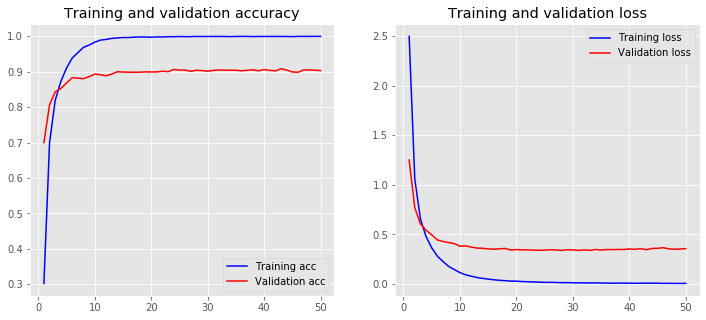

In [ ]:
plot_history(history)

In [ ]:
print("Traning Model...")
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Train on 15077 samples, validate on 3769 samples
Epoch 1/10
15077/15077 [==============================] - 608s 40ms/step - loss: 2.1001 - acc: 0.4096 - val_loss: 0.9339 - val_acc: 0.7482

Epoch 00001: val_acc improved from -inf to 0.74821, saving model to weights_cnn_sentece.hdf5
Epoch 2/10
15077/15077 [==============================] - 603s 40ms/step - loss: 0.7709 - acc: 0.7798 - val_loss: 0.6271 - val_acc: 0.8267

Epoch 00002: val_acc improved from 0.74821 to 0.82674, saving model to weights_cnn_sentece.hdf5
Epoch 3/10
15077/15077 [==============================] - 606s 40ms/step - loss: 0.4837 - acc: 0.8703 - val_loss: 0.5147 - val_acc: 0.8573

Epoch 00003: val_acc improved from 0.82674 to 0.85726, saving model to weights_cnn_sentece.hdf5
Epoch 4/10
15077/15077 [==============================] - 604s 40ms/step - loss: 0.3273 - acc: 0.9160 - val_loss: 0.4577 - val_acc: 0.8703

Epoch 00004: val_acc improved from 0.85726 to 0.87026, saving model to weights_cnn_sentec

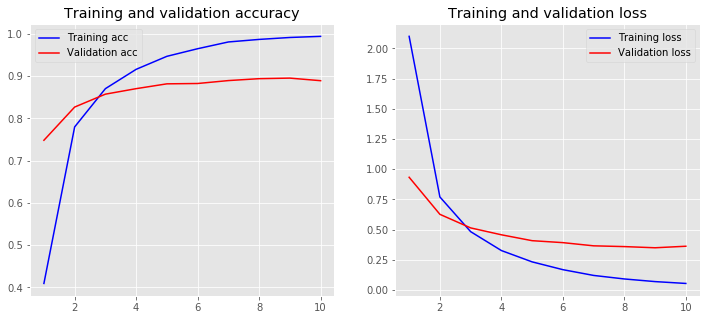

In [ ]:
plot_history(history)